#Preliminary operations

##Import libraries

In [12]:
# import main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
# import seaborn as sns
import seaborn as sns

In [2]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# stats
from scipy import stats
#scaling, normalization
from sklearn.preprocessing import StandardScaler
# train, test, split
from sklearn.model_selection import train_test_split
# KNN
from sklearn.neighbors import KNeighborsClassifier
# repeated stratified kfold
from sklearn.model_selection import RepeatedStratifiedKFold
# grid search cv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# Dummy clf
from sklearn.dummy import DummyClassifier
# metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

# scikit-plot
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve

In [4]:
dummy_clf = DummyClassifier(
    strategy="stratified", 
    random_state=0
)

##Mount Google Drive

In [5]:
# mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Import datasets

In [6]:
# import dataframe (without outliers)
df = pd.read_excel("drive/MyDrive/Progetto Data Mining 1/Data Understanding & Preparation/Data prepared final/df_opt.xlsx", index_col="Unnamed: 0")
df_emph_high = pd.read_excel("drive/MyDrive/Progetto Data Mining 1/Data Understanding & Preparation/Data prepared final/df_opt_emph_high.xlsx", index_col="Unnamed: 0")
df_emph_low = pd.read_excel("drive/MyDrive/Progetto Data Mining 1/Data Understanding & Preparation/Data prepared final/df_opt_emph_low.xlsx", index_col="Unnamed: 0")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2452 entries, 0 to 2451
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   vocal_channel        2452 non-null   object 
 1   emotion              2452 non-null   object 
 2   emotional_intensity  2452 non-null   object 
 3   statement            2452 non-null   object 
 4   repetition           2452 non-null   object 
 5   actor                2452 non-null   int64  
 6   sex                  2452 non-null   object 
 7   channels             2452 non-null   int64  
 8   length_ms            2452 non-null   float64
 9   intensity            2452 non-null   float64
 10  zero_crossings_sum   2452 non-null   float64
 11  mfcc_mean            2452 non-null   float64
 12  mfcc_max             2452 non-null   float64
 13  sc_mean              2452 non-null   float64
 14  sc_std               2452 non-null   float64
 15  sc_min               2452 non-null   f

In [8]:
# get data columns
df_data = df.loc[:, "length_ms":"skew"]
df_data_emph_high = df_emph_high.loc[:, "length_ms":"skew"]
df_data_emph_low = df_emph_low.loc[:, "length_ms":"skew"]

# get values from data columns
X = df_data.values
X_emph_high = df_data_emph_high.values
X_emph_low = df_data_emph_low.values

# get emotion lables from each emphasis group
y_emotion = df["emotion"]
y_emotion_emph_high = df_emph_high["emotion"]
y_emotion_emph_low = df_emph_low["emotion"]

# get emotion type from each emphasis group
y_emtype = df["emotion_type"]
y_emtype_emph_high = df_emph_high["emotion_type"]
y_emtype_emph_low = df_emph_low["emotion_type"]

#Hyperparameters tuning

In [ ]:
# split train- and test-set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emotion,
    test_size=0.2, 
    random_state=0,
    stratify=y_emotion
)

# standardizing the new training set and the test set
std_sclr = StandardScaler()
std_sclr.fit(X_train)
X_train = std_sclr.transform(X_train)
X_test = std_sclr.transform(X_test)

X_train.shape[0]//2

980

In [ ]:
# get two baseline (for validation- and for test- set)
dummy_clf = DummyClassifier(
    strategy="stratified", 
    random_state=0
)

dummy_clf.fit(
    X_train, 
    y_train
)

print(dummy_clf.score(X=None, y=y_train))
print(dummy_clf.score(X=None, y=y_test))

0.14737378888322283
0.1425661914460285


In [ ]:
# GridSearchCV
param_grid = {
    "n_neighbors": range(1, X_train.shape[0]//2),
    "weights": ["uniform", "distance"],
    "metric": ["cityblock", "euclidean"]
}

KNC = KNeighborsClassifier(
        n_jobs = -1
)

RSKF = RepeatedStratifiedKFold(
        n_splits = 20, 
        n_repeats = 3, 
        random_state = 0
)

grid = RandomizedSearchCV(
    KNC,
    n_iter=1500,
    param_distributions = param_grid,
    cv=RSKF,
    n_jobs = -1,
    refit = True,
    verbose=1,
    random_state=0
)

# fit GridSearchCV
grid.fit(X_train, y_train)

Fitting 60 folds for each of 1500 candidates, totalling 90000 fits


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=20, random_state=0),
                   estimator=KNeighborsClassifier(n_jobs=-1), n_iter=1500,
                   n_jobs=-1,
                   param_distributions={'metric': ['cityblock', 'euclidean'],
                                        'n_neighbors': range(1, 980),
                                        'weights': ['uniform', 'distance']},
                   random_state=0, verbose=1)

In [ ]:
print(grid.best_params_)
print(grid.best_score_)

{'weights': 'distance', 'n_neighbors': 3, 'metric': 'cityblock'}
0.4103397924826496


In [ ]:
clf = grid.best_estimator_
clf.score(X_test, y_test)

0.42362525458248473

In [ ]:
grid_res = pd.DataFrame(grid.cv_results_)
grid_res.to_excel("knn_grid_res.xlsx") 

## Tuning analysis

In [9]:
grid_res = pd.read_excel("drive/MyDrive/Progetto Data Mining 1/Classification/Hyperparameters tuning results/KNN_grid_res.xlsx")

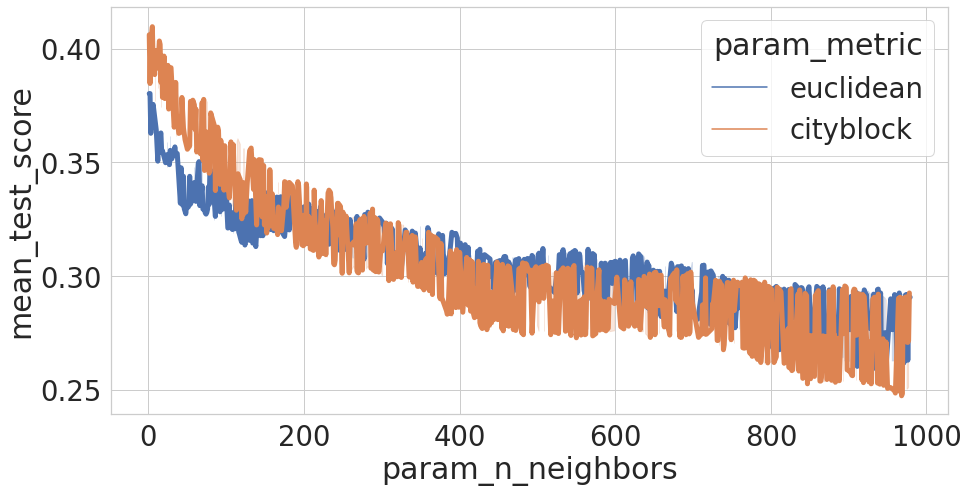

In [31]:
plt.figure(figsize=(15,7.5))
sns.set_theme(font_scale=2.5)
sns.set_style("whitegrid")
sns.lineplot(data=grid_res, x="param_n_neighbors", y="mean_test_score", hue="param_metric", linewidth = 5)
plt.show()

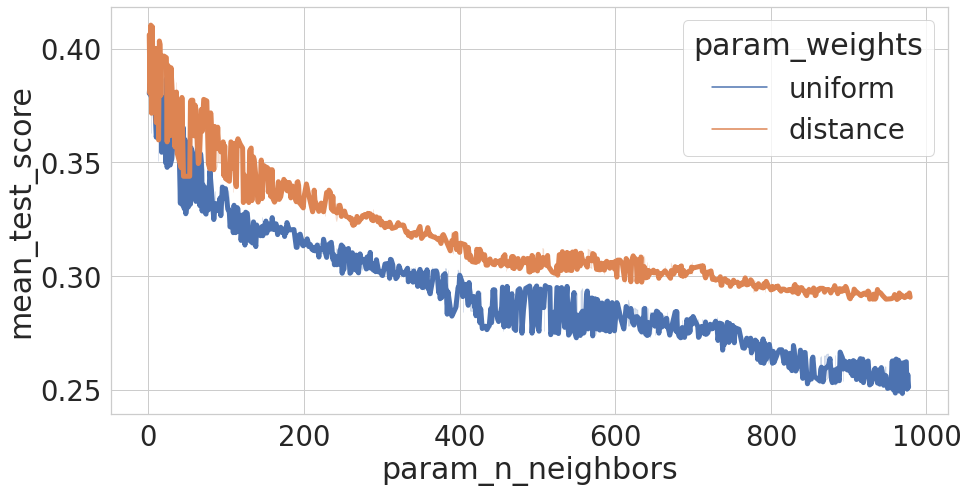

In [32]:
plt.figure(figsize=(15,7.5))
sns.set_theme(font_scale=2.5)
sns.set_style("whitegrid")
sns.lineplot(data=grid_res, x="param_n_neighbors", y="mean_test_score", hue="param_weights", linewidth = 5)
plt.show()

##Tuned model

In [ ]:
# optimized Decision Tree DT
KNC = KNeighborsClassifier(
    n_neighbors=3, 
    metric="cityblock", 
    weights="distance"
)

#Emotions classification

##All emphasis

In [ ]:
# split train- and test- set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emotion,
    test_size=0.2, 
    random_state=0,
    stratify=y_emotion
)

# standardizing the new training set and the test set
std_sclr = StandardScaler()
std_sclr.fit(X_train)
X_train = std_sclr.transform(X_train)
X_test = std_sclr.transform(X_test)

KNC_all = KNC.fit(X_train, y_train)
y_pred = KNC_all.predict(X_test)
y_test_pred_proba = KNC_all.predict_proba(X_test)

dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

0.1425661914460285
              precision    recall  f1-score   support

       angry       0.50      0.49      0.50        75
        calm       0.55      0.47      0.50        75
     disgust       0.24      0.23      0.23        39
     fearful       0.51      0.41      0.46        75
       happy       0.35      0.39      0.36        75
     neutral       0.36      0.45      0.40        38
         sad       0.39      0.36      0.37        75
   surprised       0.43      0.59      0.50        39

    accuracy                           0.42       491
   macro avg       0.41      0.42      0.42       491
weighted avg       0.43      0.42      0.42       491

0.759606328400811


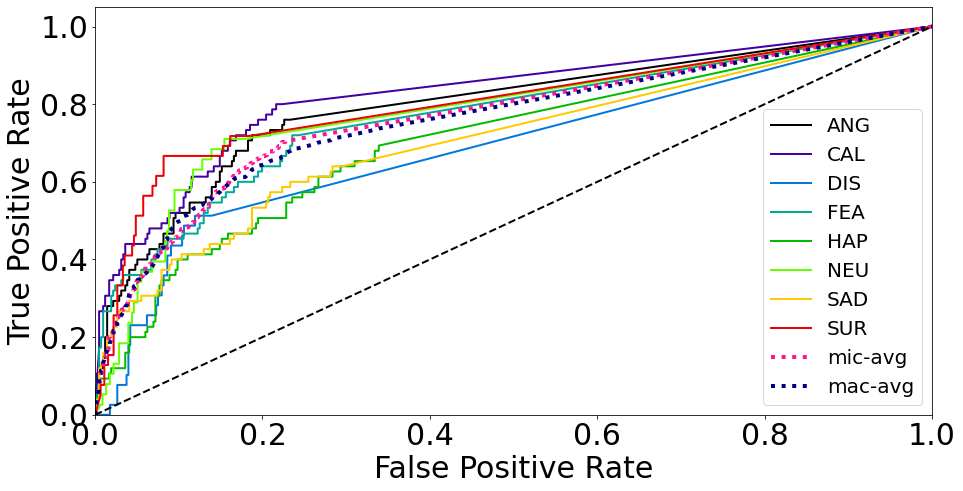

In [ ]:
plot_roc(y_test, y_test_pred_proba, figsize=(15, 7.5), text_fontsize=30, title=None)
plt.legend(["ANG", "CAL", "DIS", "FEA", "HAP", "NEU", "SAD", "SUR", "mic-avg", "mac-avg"], fontsize=20)

plt.savefig("KNN_roc_curve.svg", format="svg")
plt.show()

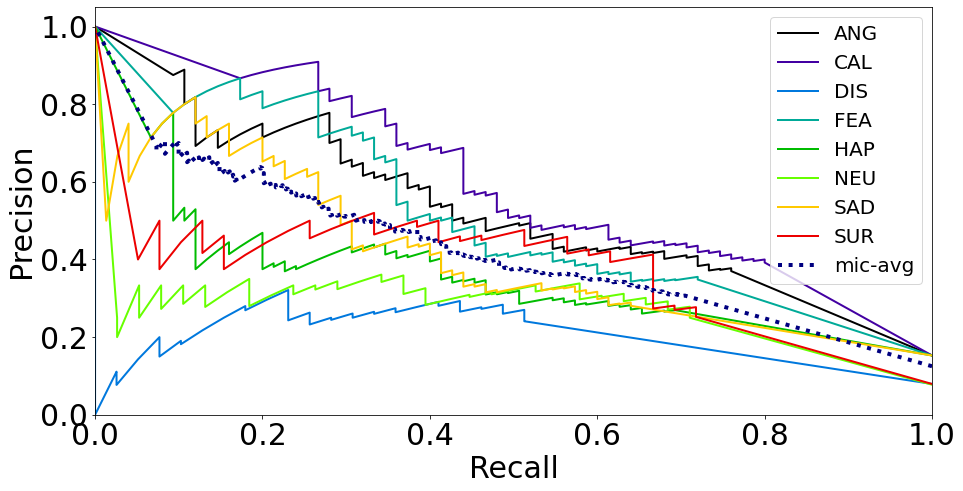

In [ ]:
plot_precision_recall(y_test, y_test_pred_proba, figsize=(15, 7.5), text_fontsize=30, title=None)
plt.legend(["ANG", "CAL", "DIS", "FEA", "HAP", "NEU", "SAD", "SUR", "mic-avg"], fontsize=20)
plt.xlabel("Recall", fontsize=30)
plt.ylabel("Precision", fontsize=30)

plt.savefig("KNN_precision_recall.svg", format="svg")
plt.show()

##All emphasis (50% samples)

In [ ]:
# split train- and test- set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emotion,
    train_size=0.5,
    test_size=0.2, 
    random_state=0,
    stratify=y_emotion
)

# standardizing the new training set and the test set
std_sclr = StandardScaler()
std_sclr.fit(X_train)
X_train_all50 = std_sclr.transform(X_train)
X_test_all50 = std_sclr.transform(X_test)

KNC_all50 = KNC.fit(X_train_all50, y_train)
y_pred = KNC_all50.predict(X_test_all50)
y_test_pred_proba = KNC_all.predict_proba(X_test_all50)

dummy_clf.fit(X_train_all50, y_train)

print(dummy_clf.score(X_test_all50, y_test))
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

0.13441955193482688
              precision    recall  f1-score   support

       angry       0.46      0.47      0.46        75
        calm       0.51      0.47      0.49        75
     disgust       0.29      0.23      0.26        39
     fearful       0.37      0.36      0.36        75
       happy       0.33      0.33      0.33        75
     neutral       0.38      0.37      0.37        38
         sad       0.24      0.24      0.24        75
   surprised       0.31      0.44      0.36        39

    accuracy                           0.37       491
   macro avg       0.36      0.36      0.36       491
weighted avg       0.37      0.37      0.37       491

0.7256960973861414


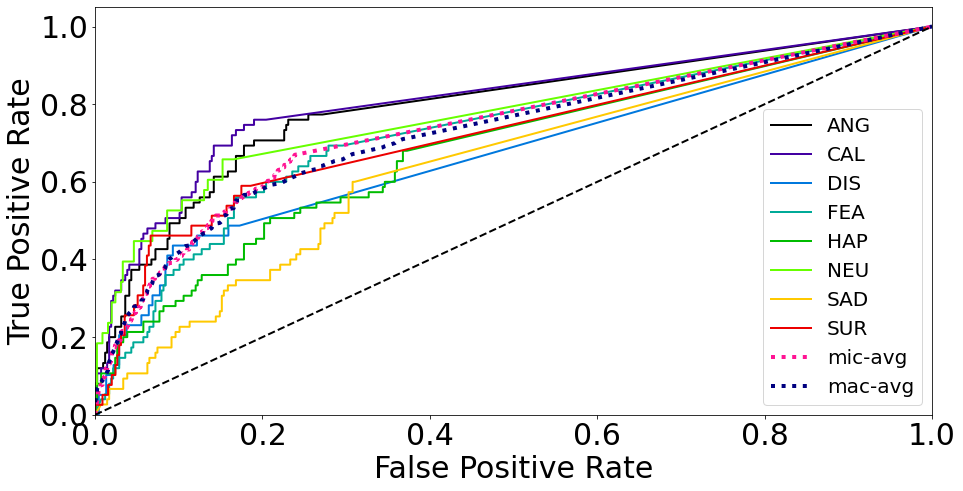

In [ ]:
plot_roc(y_test, y_test_pred_proba, figsize=(15, 7.5), text_fontsize=30, title=None)
plt.legend(["ANG", "CAL", "DIS", "FEA", "HAP", "NEU", "SAD", "SUR", "mic-avg", "mac-avg"], fontsize=20)

plt.savefig("DT_roc_curve.svg", format="svg")
plt.show()

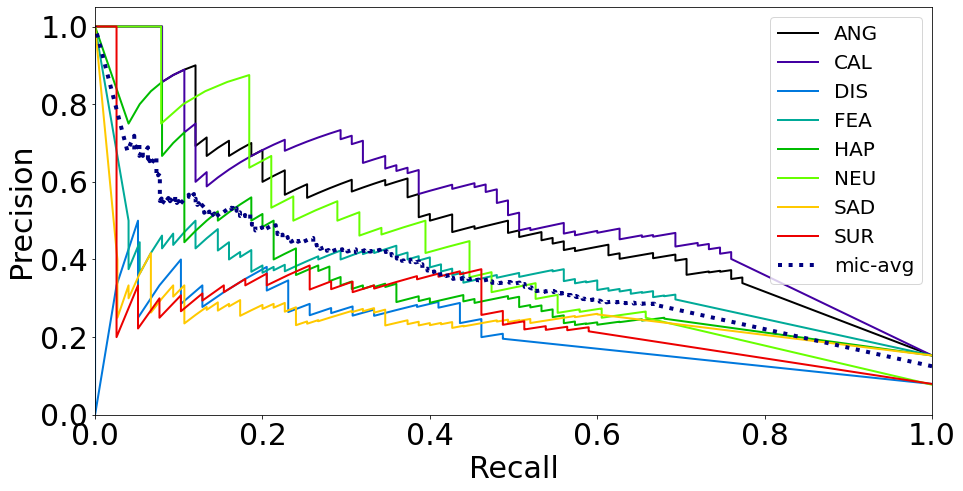

In [ ]:
plot_precision_recall(y_test, y_test_pred_proba, figsize=(15, 7.5), text_fontsize=30, title=None)
plt.legend(["ANG", "CAL", "DIS", "FEA", "HAP", "NEU", "SAD", "SUR", "mic-avg"], fontsize=20)
plt.xlabel("Recall", fontsize=30)
plt.ylabel("Precision", fontsize=30)

plt.savefig("DT_precision_recall.svg", format="svg")
plt.show()

##High emphasis

In [ ]:
# split train- and test- set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emotion,
    test_size=0.2, 
    random_state=0,
    stratify=y_emotion
)

X_train_index = df_data_emph_high.index
X_train_index = np.setdiff1d(X_train_index, y_test.index)

X_train = df_data_emph_high.loc[X_train_index].values
y_train = y_emotion_emph_high[X_train_index]

# standardizing the new training set and the test set
std_sclr = StandardScaler()
std_sclr.fit(X_train)
X_train = std_sclr.transform(X_train)
X_test = std_sclr.transform(X_test)

KNC_high = KNC.fit(X_train, y_train)
y_pred = KNC_high.predict(X_test)
y_test_pred_proba = KNC_high.predict_proba(X_test)

dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

0.14867617107942974
              precision    recall  f1-score   support

       angry       0.52      0.37      0.43        75
        calm       0.44      0.37      0.41        75
     disgust       0.22      0.21      0.21        39
     fearful       0.36      0.35      0.35        75
       happy       0.22      0.24      0.23        75
     neutral       0.16      0.18      0.17        38
         sad       0.30      0.37      0.33        75
   surprised       0.31      0.36      0.33        39

    accuracy                           0.32       491
   macro avg       0.32      0.31      0.31       491
weighted avg       0.34      0.32      0.32       491

0.6881561703023459


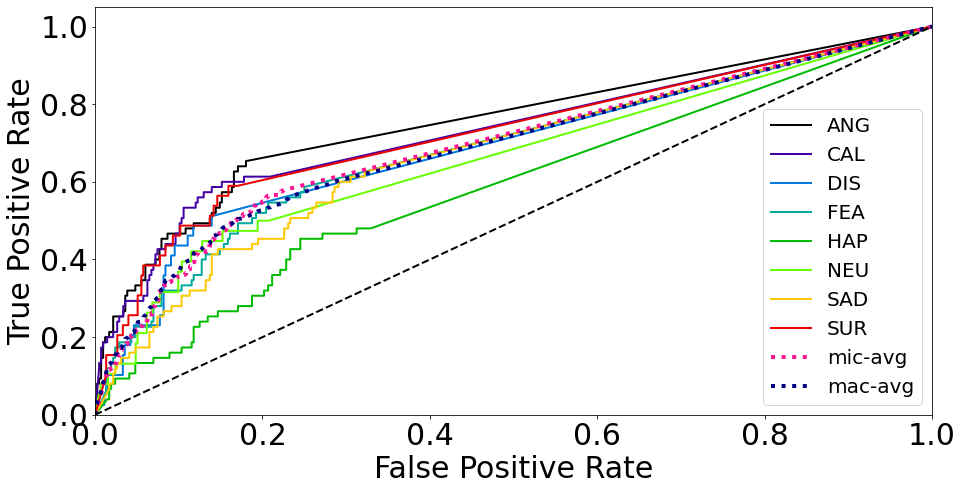

In [ ]:
plot_roc(y_test, y_test_pred_proba, figsize=(15, 7.5), text_fontsize=30, title=None)
plt.legend(["ANG", "CAL", "DIS", "FEA", "HAP", "NEU", "SAD", "SUR", "mic-avg", "mac-avg"], fontsize=20)

plt.savefig("DT_roc_curve.svg", format="svg")
plt.show()

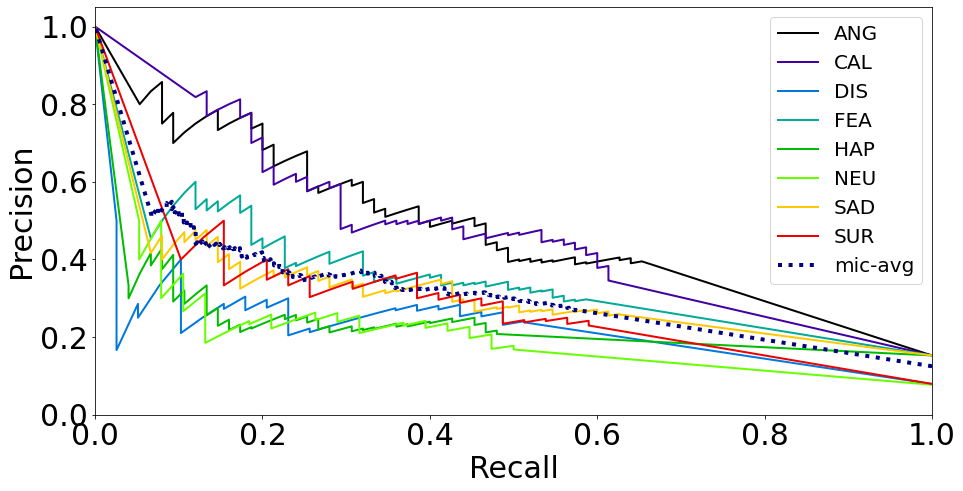

In [ ]:
plot_precision_recall(y_test, y_test_pred_proba, figsize=(15, 7.5), text_fontsize=30, title=None)
plt.legend(["ANG", "CAL", "DIS", "FEA", "HAP", "NEU", "SAD", "SUR", "mic-avg"], fontsize=20)
plt.xlabel("Recall", fontsize=30)
plt.ylabel("Precision", fontsize=30)

plt.savefig("DT_precision_recall.svg", format="svg")
plt.show()

##Low emphasis

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emotion,
    test_size=0.2, 
    random_state=0,
    stratify=y_emotion
)

# split train- and test- set
X_train_index = df_data_emph_low.index
X_train_index = np.setdiff1d(X_train_index, y_test.index)

X_train = df_data_emph_low.loc[X_train_index].values
y_train = y_emotion_emph_low[X_train_index]

# standardizing the new training set and the test set
std_sclr = StandardScaler()
std_sclr.fit(X_train)
X_train = std_sclr.transform(X_train)
X_test = std_sclr.transform(X_test)

KNC_low = KNC.fit(X_train, y_train)
y_pred = KNC_low.predict(X_test)
y_test_pred_proba = KNC_low.predict_proba(X_test)

dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

0.14663951120162932
              precision    recall  f1-score   support

       angry       0.39      0.47      0.42        75
        calm       0.46      0.35      0.40        75
     disgust       0.19      0.18      0.18        39
     fearful       0.36      0.28      0.31        75
       happy       0.25      0.29      0.27        75
     neutral       0.26      0.24      0.25        38
         sad       0.18      0.21      0.19        75
   surprised       0.33      0.31      0.32        39

    accuracy                           0.30       491
   macro avg       0.30      0.29      0.29       491
weighted avg       0.31      0.30      0.30       491

0.6740181073525017


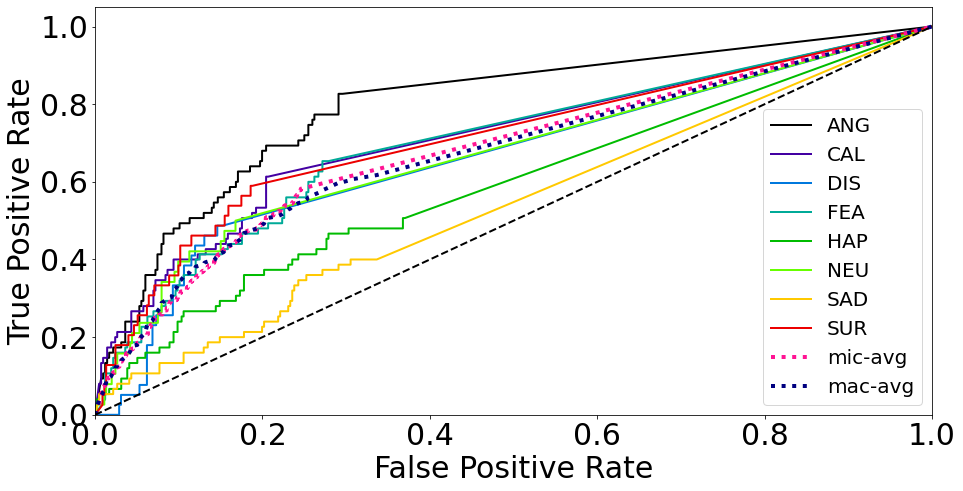

In [ ]:
plot_roc(y_test, y_test_pred_proba, figsize=(15, 7.5), text_fontsize=30, title=None)
plt.legend(["ANG", "CAL", "DIS", "FEA", "HAP", "NEU", "SAD", "SUR", "mic-avg", "mac-avg"], fontsize=20)

plt.savefig("DT_roc_curve.svg", format="svg")
plt.show()

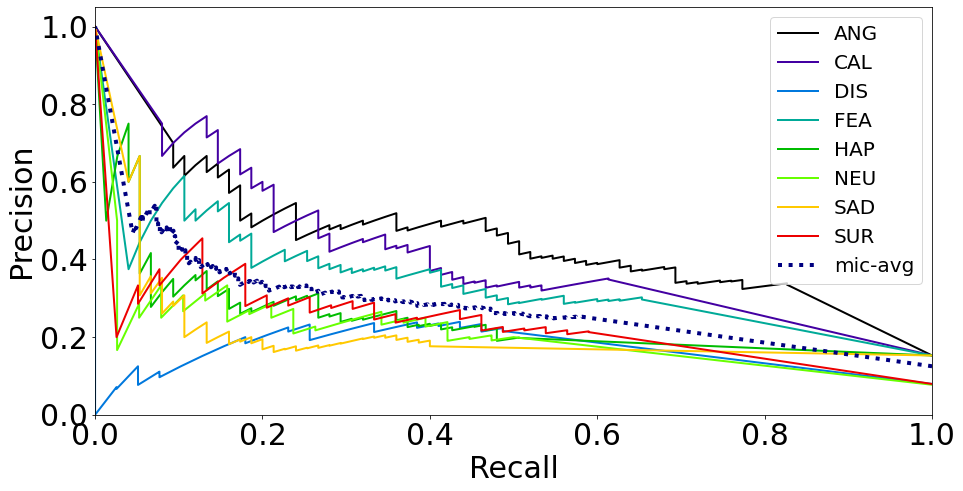

In [ ]:
plot_precision_recall(y_test, y_test_pred_proba, figsize=(15, 7.5), text_fontsize=30, title=None)
plt.legend(["ANG", "CAL", "DIS", "FEA", "HAP", "NEU", "SAD", "SUR", "mic-avg"], fontsize=20)
plt.xlabel("Recall", fontsize=30)
plt.ylabel("Precision", fontsize=30)

plt.savefig("DT_precision_recall.svg", format="svg")
plt.show()

#Emotion-type classification

##All emphasis

In [ ]:
# split train- and test- set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emtype,
    test_size=0.2, 
    random_state=0,
    stratify=y_emtype
)

# standardizing the new training set and the test set
std_sclr = StandardScaler()
std_sclr.fit(X_train)
X_train = std_sclr.transform(X_train)
X_test = std_sclr.transform(X_test)

KNC_all = KNC.fit(X_train, y_train)
y_pred = KNC_all.predict(X_test)
y_test_pred_proba = KNC_all.predict_proba(X_test)[:, 1]

dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

0.4969450101832994
              precision    recall  f1-score   support

      strong       0.84      0.85      0.85       303
        weak       0.76      0.73      0.75       188

    accuracy                           0.81       491
   macro avg       0.80      0.79      0.80       491
weighted avg       0.81      0.81      0.81       491

0.8699353977950988


##All emphasis (50% samples)

In [ ]:
# split train- and test- set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emtype,
    train_size=0.5,
    test_size=0.2, 
    random_state=0,
    stratify=y_emtype
)

# standardizing the new training set and the test set
std_sclr = StandardScaler()
std_sclr.fit(X_train)
X_train = std_sclr.transform(X_train)
X_test = std_sclr.transform(X_test)

KNC_all50 = KNC.fit(X_train, y_train)
y_pred = KNC_all50.predict(X_test)
y_test_pred_proba = KNC_all.predict_proba(X_test)[:, 1]

dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

0.5213849287169042
              precision    recall  f1-score   support

      strong       0.78      0.84      0.81       303
        weak       0.71      0.61      0.66       188

    accuracy                           0.75       491
   macro avg       0.74      0.73      0.73       491
weighted avg       0.75      0.75      0.75       491

0.7845744680851063


##High emphasis

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emtype,
    test_size=0.2, 
    random_state=0,
    stratify=y_emtype
)

X_train_index = df_data_emph_high.index
X_train_index = np.setdiff1d(X_train_index, y_test.index)

X_train = df_data_emph_high.loc[X_train_index].values
y_train = y_emtype_emph_high[X_train_index]

# standardizing the new training set and the test set
std_sclr = StandardScaler()
std_sclr.fit(X_train)
X_train = std_sclr.transform(X_train)
X_test = std_sclr.transform(X_test)

KNC_high = KNC.fit(X_train, y_train)
y_pred = KNC_high.predict(X_test)
y_test_pred_proba = KNC_high.predict_proba(X_test)[:, 1]

dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

0.4908350305498982
              precision    recall  f1-score   support

      strong       0.79      0.74      0.76       303
        weak       0.61      0.68      0.64       188

    accuracy                           0.71       491
   macro avg       0.70      0.71      0.70       491
weighted avg       0.72      0.71      0.72       491

0.7561881188118811


##Low emphasis

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emtype,
    test_size=0.2, 
    random_state=0,
    stratify=y_emtype
)

# split train- and test- set
X_train_index = df_data_emph_low.index
X_train_index = np.setdiff1d(X_train_index, y_test.index)

X_train = df_data_emph_low.loc[X_train_index].values
y_train = y_emtype_emph_low[X_train_index]

# standardizing the new training set and the test set
std_sclr = StandardScaler()
std_sclr.fit(X_train)
X_train = std_sclr.transform(X_train)
X_test = std_sclr.transform(X_test)

KNC_low = KNC.fit(X_train, y_train)
y_pred = KNC_low.predict(X_test)
y_test_pred_proba = KNC_low.predict_proba(X_test)[:, 1]

dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

0.4908350305498982
              precision    recall  f1-score   support

      strong       0.67      0.77      0.72       303
        weak       0.52      0.40      0.45       188

    accuracy                           0.63       491
   macro avg       0.60      0.58      0.59       491
weighted avg       0.61      0.63      0.62       491

0.615353556632259
